# Clustering networks

In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log
_log.setLevel('ERROR')

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import Counter
from hdbscan import HDBSCAN
from matplotlib.cm import get_cmap
from sklearn.manifold import spectral_embedding
from umap import UMAP

%matplotlib inline

seed = 42
np.random.seed(seed)
random_state = np.random.RandomState(seed)

Defining the network:

In [2]:
# G = nx.read_edgelist("air_traffic.edgelist")
# G = nx.read_edgelist("academic_collaboration.edgelist")
# G = nx.dorogovtsev_goltsev_mendes_graph(7)
with open("imdb.p", "rb") as f:
    G = nx.Graph()
    G.add_edges_from(pickle.load(f))
    G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

Reducing dimensions with Spectral Embedding and UMAP and clustering with HDBSCAN:

nodes: 32126
clusters: 9
noise level: 0.451


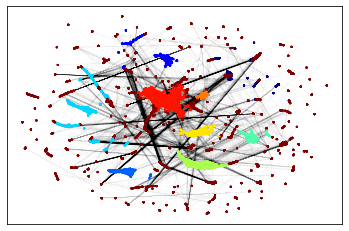

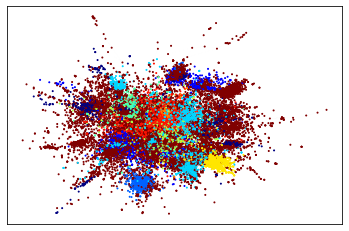

In [3]:
adj_matrix = nx.to_numpy_array(G)
node_list = list(G.nodes()) 

embedding = spectral_embedding(adj_matrix, n_components=300, drop_first=False, random_state=random_state)
embedding = UMAP(n_components=2, n_neighbors=30, min_dist=0.0, random_state=random_state).fit_transform(embedding)
clusters = HDBSCAN(min_samples=600, min_cluster_size=600, core_dist_n_jobs=-1).fit_predict(embedding)

print(f"nodes: {len(node_list)}")
print(f"clusters: {np.amax(clusters) + 1}")
print(f"noise level: {np.round(Counter(clusters)[-1] / len(clusters), 3)}")

cmap = get_cmap('jet')(np.linspace(0, 1.0, np.amax(clusters) + 2))
pos_fr = nx.fruchterman_reingold_layout(G, seed=seed)
pos_spectral_umap = {node_list[i]: embedding[i] for i in range(len(node_list))}

def draw_network(G, pos, node_color, edge_width, font_size, pdf_name):
    degrees = [x[1] for x in nx.degree(G)]
    node_sizes = [50 * x / max(degrees) + 1 for x in degrees]
    nx.draw_networkx_nodes(G, pos=pos, node_size=1, node_color=node_color)
    nx.draw_networkx_edges(G, pos=pos, width=edge_width)
    # nx.draw_networkx_labels(G, pos=pos, font_size=font_size)
    plt.savefig(f"{pdf_name}.pdf")
    plt.show()

node_colors = [cmap[clusters[i]] for i in range(len(clusters))]
draw_network(G, pos=pos_spectral_umap, node_color=node_colors, edge_width=.001, font_size=1,
             pdf_name="graph_spectral_umap")
draw_network(G, pos=pos_fr, node_color=node_colors, edge_width=.001, font_size=1, pdf_name="graph_fr")

Removing nodes labeled as noise by HDBSCAN:

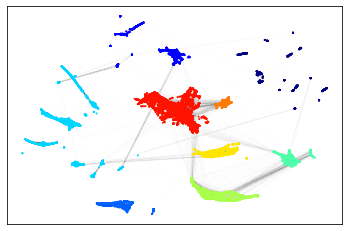

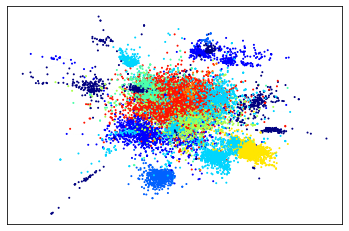

In [4]:
G.remove_nodes_from([node_list[i] for i in range(len(node_list)) if clusters[i] == -1])
node_list = list(G.nodes())
clusters = [clusters[i] for i in range(len(clusters)) if clusters[i] != -1]

node_colors = [cmap[clusters[i]] for i in range(len(clusters))]
draw_network(G, pos=pos_spectral_umap, node_color=node_colors, edge_width=.001, font_size=1,
             pdf_name="graph_without_noise_spectral_umap")
draw_network(G, pos=pos_fr, node_color=node_colors, edge_width=.001, font_size=1, pdf_name="graph_without_noise_fr")